In [26]:
from shapely.geometry import Point, Polygon
from lbmpy.relaxationrates import relaxation_rate_from_lattice_viscosity
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

from lbmpy.relaxationrates import relaxation_rate_from_lattice_viscosity
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
from lbmpy.session import *


reference_length = 17
maximal_velocity = 0.05
reynolds_number = 100000
kinematic_vicosity = (reference_length * maximal_velocity) / reynolds_number
initial_velocity=(maximal_velocity, 0)

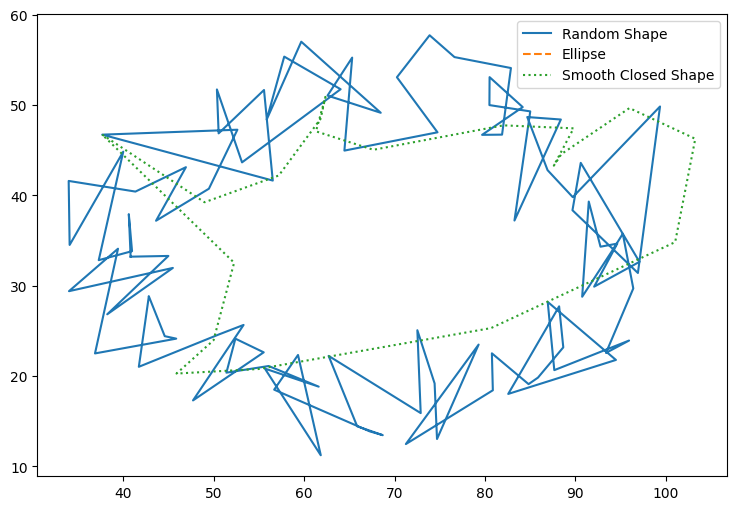

11 20


In [27]:




def generate_random_shape(ellipse_center, ellipse_axes, num_points=100, perturbation_scale=0.2):
    angle = np.linspace(0, 2*np.pi, num_points)
    ellipse_points = np.array([
        ellipse_center[0] + ellipse_axes[0] * np.cos(angle),
        ellipse_center[1] + ellipse_axes[1] * np.sin(angle)
    ]).T

    # Perturb the points to create a more randomly shaped polygon
    perturbation = np.random.normal(scale=perturbation_scale, size=(num_points, 2))
    random_shape_points = ellipse_points + perturbation

    # Ensure the shape is closed
    random_shape_points = np.vstack([random_shape_points, random_shape_points[0]])

    # Create a Shapely Polygon
    random_shape = Polygon(random_shape_points)

    return random_shape

def genshape(random_shape, num_smooth_points=9):
    # Extract coordinates from the random shape
    x, y = random_shape.exterior.xy

    # Randomly select indices to pick points
    selected_indices = np.random.choice(len(x) - 1, size=num_smooth_points, replace=False)

    # Sort indices for smoother curve
    selected_indices.sort()

    # Use selected points for smoothing
    smooth_x = np.array(x)[selected_indices]
    smooth_y = np.array(y)[selected_indices]

    # Add the first point at the end to close the curve
    smooth_x = np.append(smooth_x, smooth_x[0])
    smooth_y = np.append(smooth_y, smooth_y[0])

    return smooth_x, smooth_y
    
def smooth_closed_shape(smooth_x, smooth_y):
    # print(smooth_x, smooth_y)
    # Perform cubic spline interpolation
    t = np.arange(len(smooth_x))
    cs_x = CubicSpline(t, smooth_x)
    cs_y = CubicSpline(t, smooth_y)

    # Generate smooth points
    smooth_t = np.linspace(0, len(smooth_x) - 1, 20)
    smooth_points = np.column_stack((cs_x(smooth_t), cs_y(smooth_t)))

    return smooth_points




def set_ellipsoid(x, y, smooth_points):
    points_within = np.zeros_like(x, dtype=bool)
    if np.isscalar(x):  # Check if x is a scalar (single point)
        point = Point(x, y)
        ss = Polygon(smooth_points)
        points_within = point.within(ss)
    else:
        ss = Polygon(smooth_points)  # Define ss outside the loop
        for i in range(len(x)):
            for j in range(len(x[i])):
                point = Point(x[i, j], y[i, j])
                points_within[i, j] = point.within(ss)
    return points_within




omega = relaxation_rate_from_lattice_viscosity(kinematic_vicosity)


stencil = LBStencil(Stencil.D2Q9)
domain_size = (reference_length * 12, reference_length * 4)
dim = len(domain_size)






# Example usage with increased randomness (larger perturbation scale)
ellipse_center = (domain_size[0] // 3, domain_size[1] // 2)
ellipse_axes = (reference_length-44 , reference_length )  # Adjusted for a more horizontally flattened shape

random_shape = generate_random_shape(ellipse_center, ellipse_axes, perturbation_scale=3.74)


# Get smooth points from the random shape
f1,f2 = genshape(random_shape, num_smooth_points=10)


smooth_points= smooth_closed_shape(f1,f2)
smoothshape = Polygon(smooth_points)

# Calculate the surface area
surface_area = smoothshape.area

# for i in zip(f1,f2):
#     print(i)

# Plot the random shape, ellipse, and the smooth closed shape
fig, ax = plt.subplots()
ax.plot(*random_shape.exterior.xy, label='Random Shape')
ellipse = Point(ellipse_center).buffer(ellipse_axes[0])
ax.plot(*ellipse.exterior.xy, label='Ellipse', linestyle='dashed')
ax.plot(smooth_points[:, 0], smooth_points[:, 1], label='Smooth Closed Shape', linestyle='dotted')

ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

import torch

# Assuming smooth_x and smooth_y are numpy arrays
smooth_x_tensor = torch.tensor(f1, dtype=torch.float32)
smooth_y_tensor = torch.tensor(f2, dtype=torch.float32)

# Concatenate smooth_x and smooth_y along the last dimension to create a tensor of shape (num_points, 2)
smooth_points_tensor = torch.stack((smooth_x_tensor, smooth_y_tensor), dim=-1)

print(len(smooth_points_tensor),len(smooth_points))




In [3]:
print(smooth_points_tensor,smooth_points)


tensor([[64.0480, 53.8953],
        [64.5101, 52.1170],
        [75.1452, 49.2883],
        [92.9852, 38.7493],
        [85.6893, 15.5802],
        [46.3646, 21.6953],
        [36.9293, 29.2638],
        [39.5728, 32.0991],
        [39.5782, 34.0630],
        [46.0265, 39.7590],
        [64.0480, 53.8953]]) [[64.04804545 53.89531674]
 [63.32928453 52.94800239]
 [64.77253107 52.01467084]
 [69.10667139 50.75648264]
 [77.05129884 48.82954118]
 [87.35590185 44.81783637]
 [94.38423579 34.9884536 ]
 [92.66595821 21.09705957]
 [78.23865911 14.51665045]
 [55.7619834  18.4460151 ]
 [40.43457918 24.44132924]
 [36.7132686  28.22692596]
 [37.77671444 30.47112831]
 [39.31744503 31.80840147]
 [39.5926356  32.69771602]
 [39.45101836 33.76448462]
 [41.06976082 35.73098846]
 [45.42406247 39.28949067]
 [52.94174433 45.11821443]
 [64.04804545 53.89531674]]


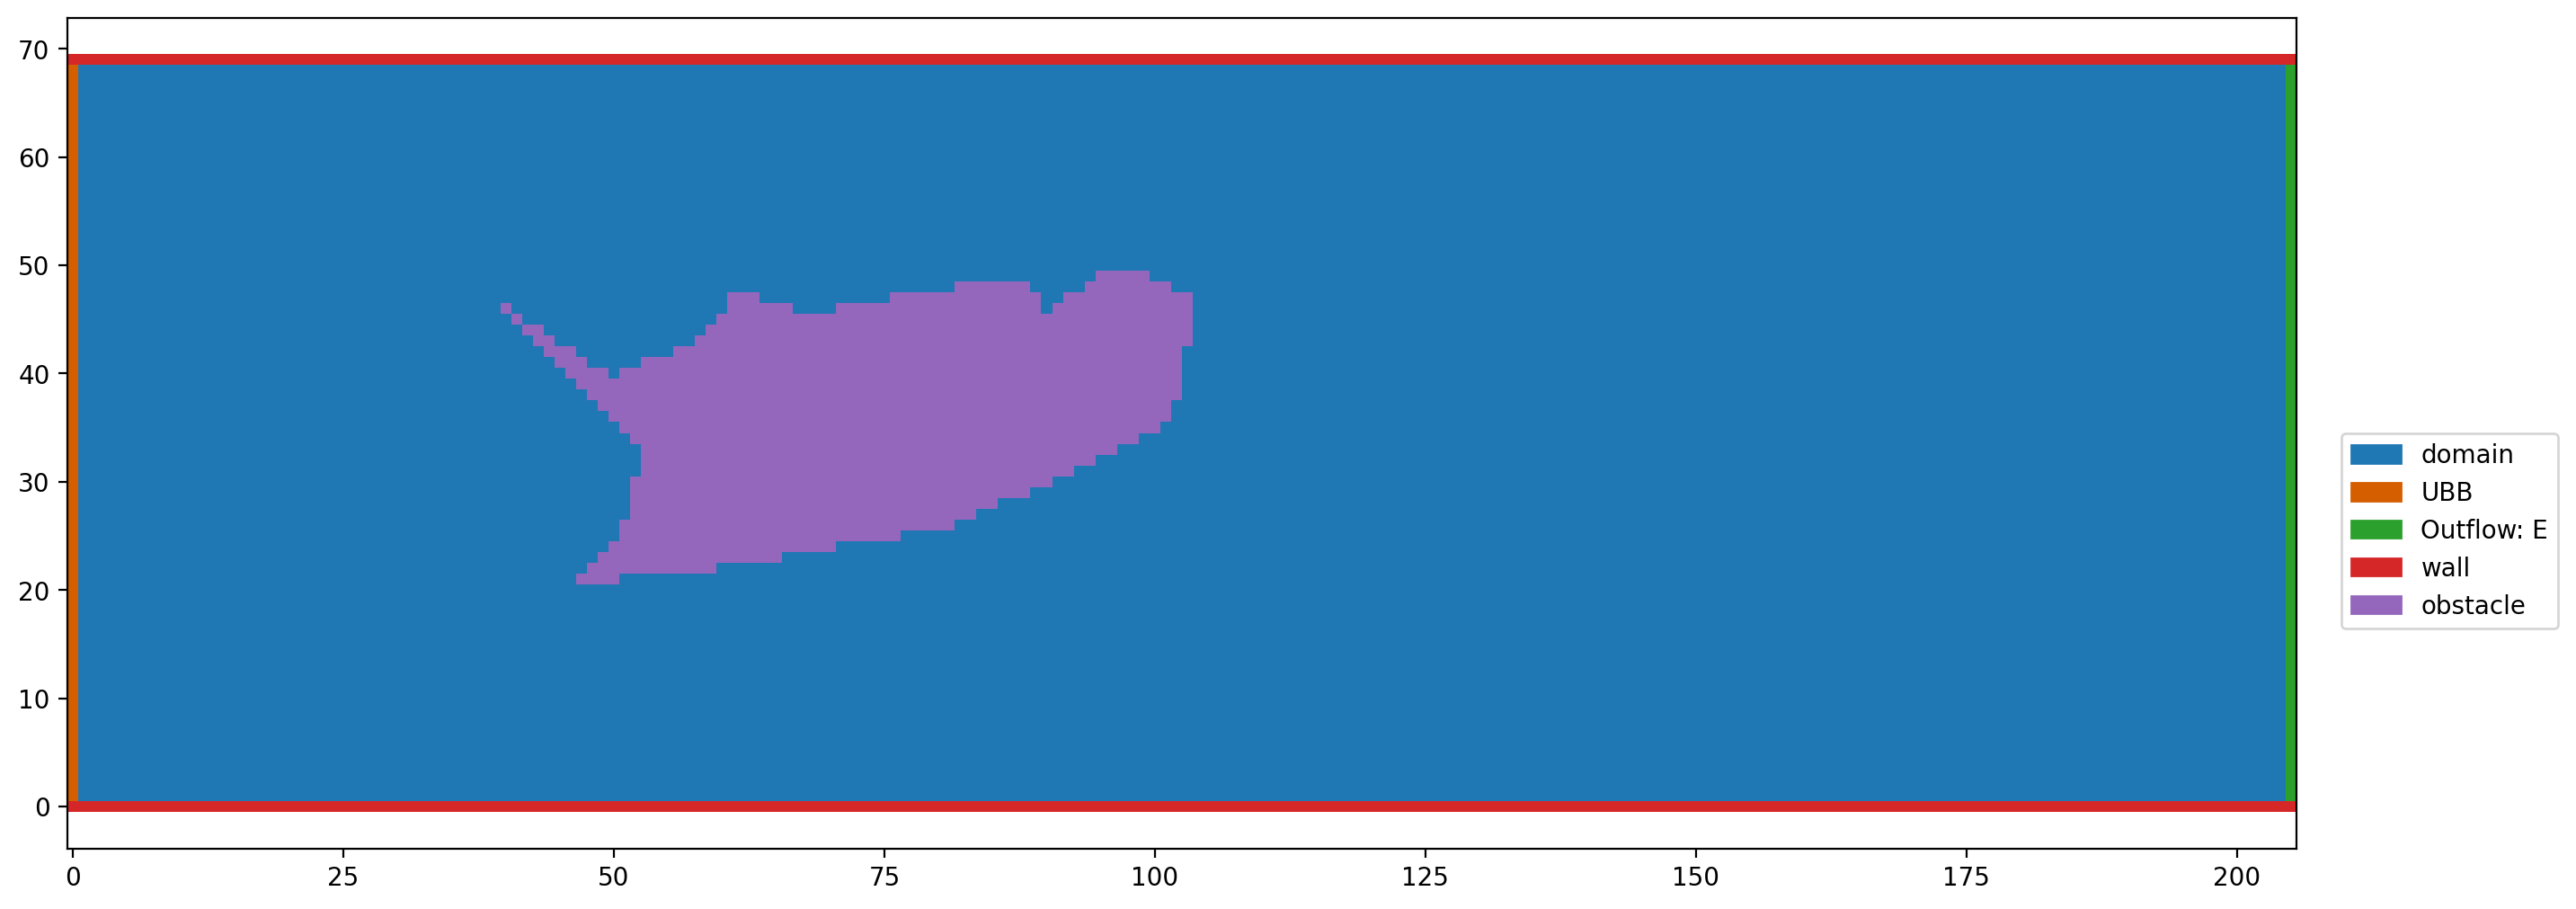

In [28]:


dh = ps.create_data_handling(domain_size=domain_size, periodicity=(False, False))

src = dh.add_array('src', values_per_cell=len(stencil), alignment=True)
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=len(stencil), alignment=True)
dh.fill('dst', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim, alignment=True)
dh.fill('velField', 0.0, ghost_layers=True)

lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.CUMULANT, relaxation_rate=omega,
                       compressible=True,
                       output={'velocity': velField}, kernel_type='stream_pull_collide')

method = create_lb_method(lbm_config=lbm_config)
method



init = pdf_initialization_assignments(method, 1.0, initial_velocity, src.center_vector)

ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)



lbm_optimisation = LBMOptimisation(symbolic_field=src, symbolic_temporary_field=dst)
update = create_lb_update_rule(lb_method=method,
                               lbm_config=lbm_config,
                               lbm_optimisation=lbm_optimisation)

ast_kernel = ps.create_kernel(update, target=dh.default_target, cpu_openmp=True)
kernel = ast_kernel.compile()


ii =0
bh = LatticeBoltzmannBoundaryHandling(method, dh, 'src', name=str(ii))

inflow = UBB(initial_velocity)
outflow = ExtrapolationOutflow(stencil[4], method)
wall = NoSlip("wall")

bh.set_boundary(inflow, slice_from_direction('W', dim))
bh.set_boundary(outflow, slice_from_direction('E', dim))
for direction in ('N', 'S'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))




bh.set_boundary(NoSlip("obstacle"), mask_callback=lambda x, y: set_ellipsoid(x, y, smooth_points))

ii+=1
plt.figure(dpi=200)
plt.boundary_handling(bh)

In [5]:
# # bh=None
# # bh = LatticeBoltzmannBoundaryHandling(method, dh, 'src',name='ls' )

# inflow = UBB(initial_velocity)
# outflow = ExtrapolationOutflow(stencil[4], method)
# wall = NoSlip("wall")

# bh.set_boundary(inflow, slice_from_direction('W', dim))
# bh.set_boundary(outflow, slice_from_direction('E', dim))
# for direction in ('N', 'S'):
#     bh.set_boundary(wall, slice_from_direction(direction, dim))
# bh.set_boundary(NoSlip("obstacle"), mask_callback=lambda x, y: set_ellipsoid(x, y, modified_points[0].detach()))

# plt.figure(dpi=200)
# plt.boundary_handling(bh)

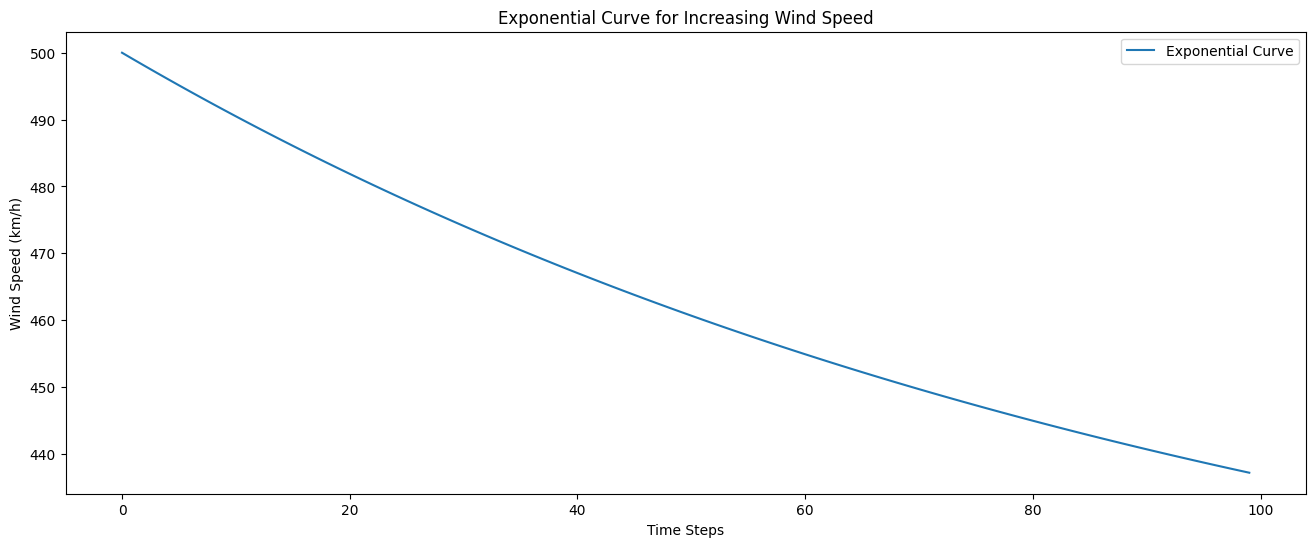

In [6]:
import numpy as np
# Parameters for the exponential curve
initial_speed = 500.0  # Initial wind speed in km/h
final_speed = 400.0   # Final wind speed in km/h
exp_factor = 0.01     # Exponential growth factor

# Calculate time-dependent wind speed using an exponential curve
time_steps = 100
time_dependent_speed = [initial_speed + (final_speed - initial_speed) * (1 - np.exp(-exp_factor * i)) for i in range(time_steps)]

# Plotting the exponential curve
plt.plot(range(time_steps), time_dependent_speed, label='Exponential Curve')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed (km/h)')
plt.title('Exponential Curve for Increasing Wind Speed')
plt.legend()
plt.show()

In [7]:
initsteps = 10
drag_forces = []
lift_forces = []
velfield = []  # List to record velocity field data
r=[]

In [8]:


# Define the number of velocity components
num_velocity_components = dh.dim
# Specify grid spacing
dx = 1.0  # Adjust based on your simulation
dy = 1.0  # Adjust based on your simulation

# Calculate cell area
cell_area = dx * dy

def calculate_forces(velocity_field_data, boundary_mask):
    # print(boundary_mask.shape,velocity_field_data.shape)
    drag_force = 0.0
    lift_force = 0.0

    # Assuming cell_area is calculated based on your grid spacing
    dx = 1.0  # Adjust based on your simulation
    dy = 1.0  # Adjust based on your simulation
    cell_area = dx * dy

    # Assuming domain_size is a tuple (360, 120)
    domain_size = velocity_field_data.shape[:-1]

    for i in range(domain_size[0]):
        for j in range(domain_size[1]):
            if  boundary_mask[i, j,0]:

                # Calculate force contribution at each boundary cell
                # Assuming drag force is proportional to velocity, and lift force uses the vertical component
                if velocity_field_data[i, j, 0]:
                    # print(velocity_field_data[i, j, 0])
                    if velocity_field_data[i, j, 0]:
                        drag_force += velocity_field_data[i, j, 0] 
                        lift_force += velocity_field_data[i, j, 1] 

    return drag_force, lift_force


from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def create_mask(domain_size, set_ellipsoid,smooth_points, dilation_pixels=16):
    mask = np.zeros((domain_size[0], domain_size[1], num_velocity_components), dtype=bool)

    x, y = np.meshgrid(np.arange(domain_size[0]), np.arange(domain_size[1]), indexing='ij')

    # Create the base ellipsoid mask using set_ellipsoid
    base_mask = np.zeros_like(mask[:, :, 0], dtype=bool)
    for i in range(domain_size[0]):
        for j in range(domain_size[1]):
            base_mask[i, j] = set_ellipsoid(x[i, j], y[i, j],smooth_points)

    # Dilate the base mask to make it larger
    dilated_mask = binary_dilation(base_mask, iterations=dilation_pixels)

    # Copy the dilated mask to all components of the 3D mask
    for k in range(num_velocity_components):
        mask[:, :, k] = dilated_mask

    return mask

# print(len(smooth_points),'lllllll')
# Create the mask
rmask = create_mask(domain_size, set_ellipsoid,smooth_points)
omask = create_mask(domain_size, set_ellipsoid,smooth_points,dilation_pixels=1)

def timeloop(timeSteps,x):
    for i in range(timeSteps):
        if i =='i':  # Assuming 5000 as the number of initial steps
            # Set constant initial speed during the initial steps
            time_dependent_speed = initial_speed
        else:
            time_dependent_speed = initial_speed + (final_speed - initial_speed) * (1 - np.exp(-exp_factor * i))
    
            # Set wind speed at the inlet (left boundary)
            vv=(time_dependent_speed, 0)
            inflow = UBB(vv)

        bh()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")
       
        vel= np.ma.array(dh.gather_array('velField'), mask=omask)
        # Record the velocity field data
        velfield.append(vel.copy())  # Copy the velocity field data to avoid modifying the original array



        drag_force, lift_force = calculate_forces(vel,rmask)

        # Append forces to the lists
        drag_forces.append(drag_force)
        lift_forces.append(lift_force)
        # print(f"Velocity field: {vel}")
        # print(f"Drag force: {drag_force}, Lift force: {lift_force}")


if 'is_test_run' not in globals():
    timeloop(initsteps,'i')  # initial steps

    def run():
        timeloop(20,'x')
        vel= np.ma.array(dh.gather_array('velField'), mask=omask)


        return vel

    fig, ax = plt.subplots()

    

    def update(frame):
        ax.clear()
        ax.set_title(f'Frame {frame}')
        vel = run()
        vel = np.transpose(vel, (1, 0, 2)) 

        # ax.quiver(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0], vel[:,:, 1], color='black', scale=4)
        ax.pcolormesh(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0] + vel[:,:, 1], cmap='cividis')
        ax.streamplot(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0], vel[:,:, 1], color='white')
        # Overlay the rmask with 50% opacity
        rmask_2d = np.any(rmask, axis=2).T  # Convert the 3D rmask to a 2D mask

        ax.contourf(np.arange(domain_size[0]), np.arange(domain_size[1]), rmask_2d, levels=[0.5, 1], colors='salmon', alpha=0.3)


        # # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, domain_size[0])
        ax.set_ylim(0, domain_size[1])
        return ax

        # Run the simulation multiple times without displaying the animation
    for _ in range(10):
        vel = run()

    

    animation = FuncAnimation(fig, update, frames=30, interval=77)
    plt.close()  # Prevent the initial figure from being displayed
    display(HTML(animation.to_html5_video()))
else:
    timeloop(10,'x')
    res = None
# res



In [75]:
def calculate_reward(initial_shape_tensor, current_shape_tensor, lift_forces, drag_forces, initial_surface_area):
    penalty_factor=0.4
    rewards = []
    # Calculate the initial surface area

    smooth_points_np = current_shape_tensor
    smooth_x = smooth_points_np[:, 0]
    smooth_y = smooth_points_np[:, 1]
    smooth_points = smooth_closed_shape(smooth_x, smooth_y)
        

    ss = Polygon(smooth_points)
    ssurface_area = ss.area
    
    area_deviation = np.abs(initial_surface_area - ssurface_area)
    # Iterate through each time step
    for i in range(len(lift_forces)):
        # Calculate the surface area of the current shape tensor
        
        current_surface_area = initial_surface_area
        
        # Calculate the mean lift and drag forces
        mean_lift_force = lift_forces[i]
        mean_drag_force = drag_forces[i]
        
        # Reward more for lift than penalty for drag
        reward = (5*mean_lift_force) - mean_drag_force
        
        # Penalize heavily for any deviation from the initial surface area
        penalty = -area_deviation * penalty_factor
        
        # Adjust the reward based on the penalty
        reward += penalty
        
        rewards.append(reward)
    print(len(rewards),len(lift_forces))
    return rewards
r = calculate_reward(smooth_points, smooth_points, lift_forces, drag_forces, surface_area)

3480 3480


# Training

In [10]:
n_steps = len(lift_forces)  # Assuming lift_forces, drag_forces, and r have the same length
smooth_points_flat = smooth_points.flatten()  # Flatten the 2D array into 1D
smooth_points_repeated = np.tile(smooth_points_flat, (n_steps, 1))  # Repeat for each time step
smooth_points_tensor = torch.tensor(smooth_points, dtype=torch.float32)


In [11]:
print(len(smooth_points_repeated), len(drag_forces))


830 830


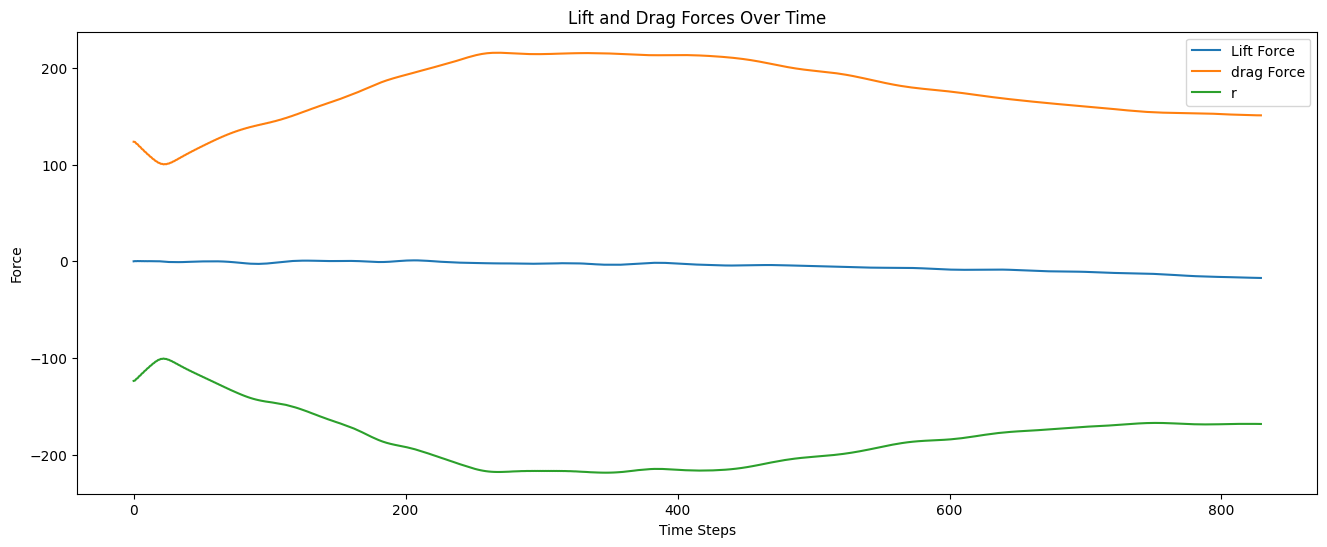

In [12]:
plt.figure()

plt.plot(range(len(lift_forces)), lift_forces, label='Lift Force')
plt.plot(range(len(drag_forces)), drag_forces, label='drag Force')
plt.plot(range(len(r)), r, label='r ')
plt.xlabel('Time Steps')
plt.ylabel('Force')
plt.title('Lift and Drag Forces Over Time')
plt.legend()

plt.show()

In [13]:
# Stack lift, drag, and rewards into a single array
forces_rewards = np.column_stack((lift_forces, drag_forces, r))
# Concatenate smooth_points with forces and rewards
training_data = np.hstack((smooth_points_repeated, forces_rewards))

# Convert numpy array to torch tensor
training_data_tensor = torch.tensor(training_data, dtype=torch.float32)
training_data_tensor.shape

torch.Size([830, 43])

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
retrain=True
class ShapeAdjusterNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ShapeAdjusterNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        adjustments = self.fc2(x)
        return adjustments



# Initialize the network
input_dim = training_data_tensor.shape[1]  # Number of input features
output_dim = smooth_points_tensor.numel()  # Number of adjustments to make (flattened smooth_points)

if  retrain:
    model = ShapeAdjusterNN(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)


IndexError: tuple index out of range

In [29]:
initsteps = 10

velfield = []  # List to record velocity field data
r=[]
def traintimeloop(timeSteps,rmask,omask):
    drag_forces = []
    lift_forces = []
    for i in range(timeSteps):
        if i =='i':  # Assuming 5000 as the number of initial steps
            # Set constant initial speed during the initial steps
            time_dependent_speed = initial_speed
        else:
            time_dependent_speed = initial_speed + (final_speed - initial_speed) * (1 - np.exp(-exp_factor * i))
    
            # Set wind speed at the inlet (left boundary)
            vv=(time_dependent_speed, 0)
            inflow = UBB(vv)

        bh()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")
       
        vel= np.ma.array(dh.gather_array('velField'), mask=omask)
        # Record the velocity field data
        velfield.append(vel.copy())  # Copy the velocity field data to avoid modifying the original array



        drag_force, lift_force = calculate_forces(vel,rmask)

        # Append forces to the lists
        drag_forces.append(drag_force)
        lift_forces.append(lift_force)
    return drag_forces,lift_forces

In [71]:
smooth_points= smooth_closed_shape(f1,f2)


smoothshape = Polygon(smooth_points)

# Calculate the surface area
surface_area = smoothshape.area

smooth_points,surface_area

(array([[ 37.64874838,  46.72914795],
        [ 48.97313446,  39.24472598],
        [ 57.19225379,  42.21013878],
        [ 61.81280501,  48.47413417],
        [ 62.35548444,  50.90769352],
        [ 61.30849543,  47.09531653],
        [ 67.6615263 ,  45.0544052 ],
        [ 82.06092058,  47.75873632],
        [ 89.8234928 ,  47.42850859],
        [ 87.6380289 ,  43.29703139],
        [ 88.4824145 ,  44.58522949],
        [ 96.00807653,  49.67047121],
        [103.2942346 ,  46.27009093],
        [101.0691166 ,  34.83507706],
        [ 80.68297216,  25.31433629],
        [ 54.9444728 ,  20.78661882],
        [ 45.87027885,  20.28393996],
        [ 49.96971087,  23.97314589],
        [ 52.24616107,  32.55409202],
        [ 37.64874838,  46.72914795]]),
 1072.6771847229256)

In [78]:

smooth_points_tensor = torch.tensor(smooth_points, dtype=torch.float32)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for episode in range(13):
    episode_rewards = []
    episode_d = []
    episode_l = []
    adjustments = []

    # Collect data over time steps
    for t in range(4):
        rmask = create_mask(domain_size, set_ellipsoid,smooth_points)
        omask = create_mask(domain_size, set_ellipsoid,smooth_points,dilation_pixels=1)

        d,l=traintimeloop(85,rmask,omask)
        r = calculate_reward(smooth_points, smooth_points, l, d, surface_area)

        l_sum = sum(l)
        d_sum = sum(d)
        r_sum = sum(r)

       
        # Prepare input data

                # Stack lift, drag, and rewards into a single array
        forces_rewards = np.column_stack((l_sum, d_sum, r_sum))
        print(forces_rewards)
        # Concatenate smooth_points with forces and rewards
        training_data = np.hstack(( smooth_points.flatten(), forces_rewards[0]))
        
        # Convert numpy array to torch tensor
        training_data_tensor = torch.tensor(training_data, dtype=torch.float32)
        
        input_data = training_data_tensor
        
        # Get the model's prediction for how to adjust smooth_points
        adjustment = model(input_data)
        adjustments.append(adjustment)

        # Apply the adjustment to smooth_points
        smooth_points = smooth_points_tensor + (0.005*adjustment.view_as(smooth_points_tensor))
        smooth_points = smooth_points.detach().numpy()
        # Calculate reward (e.g., related to lift/drag)
        reward = r_sum  # Use actual reward data here
        episode_rewards.append(reward)
        episode_l.append(l_sum)
        episode_d.append(d_sum)
        
        if t == len(lift_forces) - 1:
            break
    

    # Calculate the cumulative reward for the episode
    cumulative_reward = torch.tensor(sum(episode_rewards), dtype=torch.float32)
    cumulative_l = torch.tensor(sum(episode_l), dtype=torch.float32)
    cumulative_d = torch.tensor(sum(episode_d), dtype=torch.float32)
    # Calculate loss (negative cumulative reward for minimization)
    print(cumulative_reward,'cc')
    loss = -cumulative_reward
    loss.requires_grad_()

    lloss = -cumulative_l
    lloss.requires_grad_()

    dloss = cumulative_d
    dloss.requires_grad_()
    # Backpropagate and update the model
    optimizer.zero_grad()
    loss.backward()
    lloss.backward()
    dloss.backward()
    optimizer.step()


85 85
[[  -264.20556688  17165.67692862 -21899.51669595]]
85 85
[[   748.7702283   18506.18245421 -20242.59609321]]
85 85
[[   -81.69226796  18782.80199674 -25016.77353221]]
85 85
[[  -822.34013394  18196.75858477 -27902.79136268]]
tensor(-95061.6797) cc
85 85
[[ -1197.657876    17750.9785864  -28886.31731768]]
85 85
[[ -1797.38834288  17474.51561051 -31494.9645483 ]]
85 85
[[ -1946.44778503  16928.50355399 -31395.91873675]]
85 85
[[ -1225.51366039  16889.39619969 -27663.79390792]]
tensor(-119440.9922) cc
85 85
[[ 1.56675822e+01  1.76115708e+04 -2.24768048e+04]]
85 85
[[  1111.22664003  18110.40093331 -18033.97181368]]
85 85
[[  1179.1760716   19594.51593264 -19574.63412566]]
85 85
[[  1026.23551848  18839.67086204 -19836.61135837]]
tensor(-79922.0234) cc
85 85
[[   937.31702079  18409.4809771  -19644.79991795]]
85 85
[[   880.24200446  17353.92255328 -18787.18440443]]
85 85
[[   585.55376736  18046.38774711 -20757.79704223]]
85 85
[[   707.02250764  17581.46361631 -19718.88626765]]
te

In [66]:
smooth_points

array([[ 55.867424,  48.500504],
       [ 44.31906 ,  46.659412],
       [ 64.066216,  41.96422 ],
       [ 69.32683 ,  59.57187 ],
       [ 66.4271  ,  42.21148 ],
       [ 63.801476,  49.835564],
       [ 68.31661 ,  51.2933  ],
       [ 81.29902 ,  44.435844],
       [ 87.489494,  45.709377],
       [ 94.85183 ,  32.13117 ],
       [104.954025,  40.898174],
       [ 87.52079 ,  50.290833],
       [108.41762 ,  53.750427],
       [104.33573 ,  38.643627],
       [ 83.000854,  29.686357],
       [ 60.42265 ,  22.169588],
       [ 38.4032  ,  16.245256],
       [ 56.40927 ,  23.023048],
       [ 57.311474,  27.953495],
       [ 31.20464 ,  53.880424]], dtype=float32)

[[64.01105  54.00016 ]
 [63.566303 52.962093]
 [64.77163  51.909264]
 [69.259544 50.640427]
 [77.00717  48.79828 ]
 [87.372444 44.79698 ]
 [94.42473  35.010803]
 [92.63143  21.339958]
 [78.12688  14.682014]
 [55.8141   18.352787]
 [40.67756  24.312128]
 [36.844376 27.813335]
 [37.8306   30.398226]
 [39.172623 31.305378]
 [39.30515  32.87497 ]
 [39.560028 33.91125 ]
 [41.00726  35.824314]
 [45.10823  39.328773]
 [53.03474  45.181767]
 [64.04831  53.62242 ]] 20


C:\Users\91917\AppData\Local\Temp\ipykernel_16464\2854902499.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_smooth_points_tensor = torch.tensor(smooth_points, dtype=torch.float32)


In [79]:


# Define the number of velocity components
num_velocity_components = dh.dim
# Specify grid spacing
dx = 1.0  # Adjust based on your simulation
dy = 1.0  # Adjust based on your simulation

# Calculate cell area
cell_area = dx * dy

def calculate_forces(velocity_field_data, boundary_mask):
    # print(boundary_mask.shape,velocity_field_data.shape)
    drag_force = 0.0
    lift_force = 0.0

    # Assuming cell_area is calculated based on your grid spacing
    dx = 1.0  # Adjust based on your simulation
    dy = 1.0  # Adjust based on your simulation
    cell_area = dx * dy

    # Assuming domain_size is a tuple (360, 120)
    domain_size = velocity_field_data.shape[:-1]

    for i in range(domain_size[0]):
        for j in range(domain_size[1]):
            if  boundary_mask[i, j,0]:

                # Calculate force contribution at each boundary cell
                # Assuming drag force is proportional to velocity, and lift force uses the vertical component
                if velocity_field_data[i, j, 0]:
                    # print(velocity_field_data[i, j, 0])
                    if velocity_field_data[i, j, 0]:
                        drag_force += velocity_field_data[i, j, 0] 
                        lift_force += velocity_field_data[i, j, 1] 

    return drag_force, lift_force


from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def create_mask(domain_size, set_ellipsoid,smooth_points, dilation_pixels=16):
    mask = np.zeros((domain_size[0], domain_size[1], num_velocity_components), dtype=bool)

    x, y = np.meshgrid(np.arange(domain_size[0]), np.arange(domain_size[1]), indexing='ij')

    # Create the base ellipsoid mask using set_ellipsoid
    base_mask = np.zeros_like(mask[:, :, 0], dtype=bool)
    for i in range(domain_size[0]):
        for j in range(domain_size[1]):
            base_mask[i, j] = set_ellipsoid(x[i, j], y[i, j],smooth_points)

    # Dilate the base mask to make it larger
    dilated_mask = binary_dilation(base_mask, iterations=dilation_pixels)

    # Copy the dilated mask to all components of the 3D mask
    for k in range(num_velocity_components):
        mask[:, :, k] = dilated_mask

    return mask

# print(len(smooth_points),'lllllll')
# Create the mask
rmask = create_mask(domain_size, set_ellipsoid,smooth_points)
omask = create_mask(domain_size, set_ellipsoid,smooth_points,dilation_pixels=1)

def timeloop(timeSteps,x):
    for i in range(timeSteps):
        if i =='i':  # Assuming 5000 as the number of initial steps
            # Set constant initial speed during the initial steps
            time_dependent_speed = initial_speed
        else:
            time_dependent_speed = initial_speed + (final_speed - initial_speed) * (1 - np.exp(-exp_factor * i))
    
            # Set wind speed at the inlet (left boundary)
            vv=(time_dependent_speed, 0)
            inflow = UBB(vv)

        bh()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")
       
        vel= np.ma.array(dh.gather_array('velField'), mask=omask)
        # Record the velocity field data
        velfield.append(vel.copy())  # Copy the velocity field data to avoid modifying the original array



        drag_force, lift_force = calculate_forces(vel,rmask)

        # Append forces to the lists
        drag_forces.append(drag_force)
        lift_forces.append(lift_force)
        # print(f"Velocity field: {vel}")
        # print(f"Drag force: {drag_force}, Lift force: {lift_force}")


if 'is_test_run' not in globals():
    timeloop(initsteps,'i')  # initial steps

    def run():
        timeloop(20,'x')
        vel= np.ma.array(dh.gather_array('velField'), mask=omask)


        return vel

    fig, ax = plt.subplots()

    

    def update(frame):
        ax.clear()
        ax.set_title(f'Frame {frame}')
        vel = run()
        vel = np.transpose(vel, (1, 0, 2)) 

        # ax.quiver(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0], vel[:,:, 1], color='black', scale=4)
        ax.pcolormesh(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0] + vel[:,:, 1], cmap='cividis')
        ax.streamplot(np.arange(domain_size[0]), np.arange(domain_size[1]), vel[:,:, 0], vel[:,:, 1], color='white')
        # Overlay the rmask with 50% opacity
        rmask_2d = np.any(rmask, axis=2).T  # Convert the 3D rmask to a 2D mask

        ax.contourf(np.arange(domain_size[0]), np.arange(domain_size[1]), rmask_2d, levels=[0.5, 1], colors='salmon', alpha=0.3)


        # # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, domain_size[0])
        ax.set_ylim(0, domain_size[1])
        return ax

        # Run the simulation multiple times without displaying the animation
    for _ in range(10):
        vel = run()

    

    animation = FuncAnimation(fig, update, frames=5, interval=77)
    plt.close()  # Prevent the initial figure from being displayed
    display(HTML(animation.to_html5_video()))
else:
    timeloop(10,'x')
    res = None
# res



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
# Prepare data
X = smooth_points_tensor.repeat(len(r), 1, 1)  # Repeat the shape tensor to match the number of time steps
y = X.clone()  # Output tensor (initially same as input)

# Convert reward list to tensor
reward_tensor = torch.tensor(r, dtype=torch.float32)

class ShapeModifier(nn.Module):
    def __init__(self, input_size=20):
        super(ShapeModifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 20)  # Output 10 points

    def forward(self, x):
        # Flatten the input tensor
        x = torch.flatten(x, start_dim=1)
        # Apply linear layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        # Reshape output to match input shape
        return x.view(-1, 10, 2)  # Reshape to [batch_size, 10, 2]



# Create neural network instance
shape_modifier = ShapeModifier(input_size=20)

# Define optimizer and loss function
optimizer = optim.Adam(shape_modifier.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# Create DataLoader for batch processing
dataset = TensorDataset(X, y, reward_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y, batch_r in dataloader:
        # Forward pass
        modified_points = shape_modifier(batch_X)
        print(modified_points.shape)
        batch_r.requires_grad = True
        # Calculate MSE loss between modified points and ground truth
        loss = 1 - torch.mean(batch_r)
                # Ensure that batch_r requires gradients

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Evaluate the model
# You can now use the trained model to generate modified shapes based on input shapes


In [ ]:
modified_points[12]

In [240]:
smooth_points_tensor =modified_points[0].detach()

In [232]:
smooth_points_tensor.shape

torch.Size([10, 2])

In [82]:
smooth_points_tensor

tensor([[46.2515, 43.6178],
        [55.7688, 49.0409],
        [95.2278, 34.8019],
        [79.2851, 18.4200],
        [72.2419, 16.4730],
        [52.7784, 20.1454],
        [47.6242, 22.5875],
        [42.4303, 27.2869],
        [41.6647, 31.9240],
        [46.2515, 43.6178]])